In [1]:
# Install required packages
# Run this cell first if you encounter ModuleNotFoundError
# Option 1: Install from requirements.txt (recommended)
# !pip install -r requirements.txt

# Option 2: Install packages individually (including safetensors to avoid torch version issues)
# Uncomment the line below to install all packages:
# !pip install pandas "numpy>=1.23.0,<2.0.0" scikit-learn transformers torch safetensors textstat matplotlib seaborn yfinance

# Option 3: Install via terminal/command line:
# pip install -r requirements.txt

# Quick install for yfinance (if you get ModuleNotFoundError for yfinance):
# !pip install yfinance

# IMPORTANT NOTES:
# 1. NumPy Compatibility: PyTorch 2.2.2 requires NumPy < 2.0.0. If you encounter NumPy 2.x compatibility errors,
#    downgrade NumPy: !pip install "numpy<2.0.0"
# 2. If you encounter a ValueError about torch.load requiring torch>=2.6,
#    install safetensors: !pip install safetensors
#    The notebook will automatically use safetensors if available to bypass the torch version requirement.
# 3. PyArrow is required for sentiment caching (parquet file support):
#    If using conda: !conda install -c conda-forge pyarrow
#    If using pip: !pip install pyarrow
#    Or install from requirements.txt which includes pyarrow
# 4. yfinance is required for downloading SPY data:
#    !pip install yfinance


In [2]:
# News Sentiment Analysis for SPY Returns Prediction
# This notebook implements a comprehensive pipeline for predicting next-day SPY returns
# using news sentiment, volume, complexity, and uncertainty features

# Standard library imports
import json
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# NLP and Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Text complexity/readability metrics
from textstat import flesch_reading_ease, gunning_fog, dale_chall_readability_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date/time utilities
from datetime import datetime, timedelta

# Set style for plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
PyTorch version: 2.2.2
CUDA available: False
Pandas version: 2.3.3
NumPy version: 1.26.4


## 0. Function Definitions

All analysis functions are defined below for modularity and reusability.


In [3]:
# Import DataLoader class from data_loader.py
from data_loader import DataLoader

print("DataLoader class imported!")


DataLoader class imported!


In [4]:
# ============================================================================
# DATA EXPLORATION AND STATISTICS FUNCTIONS
# ============================================================================

# Import DataExplorer class from data_explorer.py
from data_explorer import DataExplorer

print("DataExplorer class imported!")


DataExplorer class imported!


In [5]:
# ============================================================================
# FEATURE ENGINEERING FUNCTIONS (on individual articles)
# ============================================================================

# Import feature extraction class from feature_extractor.py
from feature_extractor import ArticleFeatureExtractor

print("Feature extraction class imported!")


/Users/ayx/Documents/Projects/news
Feature extraction class imported!


## 1. Data Loading and Preparation

### 1.1 Load News Dataset


In [6]:
# Load news dataset using DataLoader class
data_loader = DataLoader()
df_news = data_loader.load_news_dataset()
df_news.head()


Loading news dataset...
Loaded 209,527 news articles
Date range: 2012-01-28 00:00:00 to 2022-09-23 00:00:00

Categories: 42
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
Name: count, dtype: int64


,link,headline,category,short_description,authors,date
0,https://www.huffingtonpost.com/entry/dwight-ho...,Dwight Howard Rips Teammates After Magic Loss ...,SPORTS,The five-time all-star center tore into his te...,,2012-01-28
1,https://www.huffingtonpost.com/entry/robots-pl...,"Robots Play Catch, Starring Agile Justin And R...",SCIENCE,"image 1: throw As Hizook reports, DLR started ...",Travis Korte,2012-01-28
2,https://www.huffingtonpost.com/entry/russian-c...,Russian Cargo Ship Docks At International Spac...,SCIENCE,Gallery: Space Station's Expedition 30 Mission...,,2012-01-28
3,https://www.huffingtonpost.com/entry/7-amazing...,7 Amazing Name Generators (PHOTOS),COMEDY,Let's be honest: most of our names are pretty ...,Seena Vali,2012-01-28
4,https://www.huffingtonpost.com/entry/mitt-romn...,Mitt Romney Madness: Florida Edition (VIDEO),COMEDY,The apparent madness that gripped Mitt Romney ...,Ben Craw,2012-01-28


In [7]:
# Compute and display statistics
data_explorer = DataExplorer()
df_news, daily_counts, monthly_counts, category_counts = data_explorer.compute_news_statistics(df_news)


NEWS DATASET STATISTICS

Dataset Overview:
- Total articles: 209,527
- Date range: 2012-01-28 00:00:00 to 2022-09-23 00:00:00
- Number of unique categories: 42
- Number of unique dates: 3890

Headline Statistics:
- Average tokens per headline: 9.6
- Median tokens per headline: 10.0
- Average characters per headline: 58.4

Daily News Statistics:
- Average news per day: 53.9
- Median news per day: 74.0
- Max news in a single day: 100
- Min news in a single day: 2

Monthly News Statistics:
- Average news per month: 1624.2
- Total months covered: 129

Top 15 Categories:
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
Name: count, dtype: int64


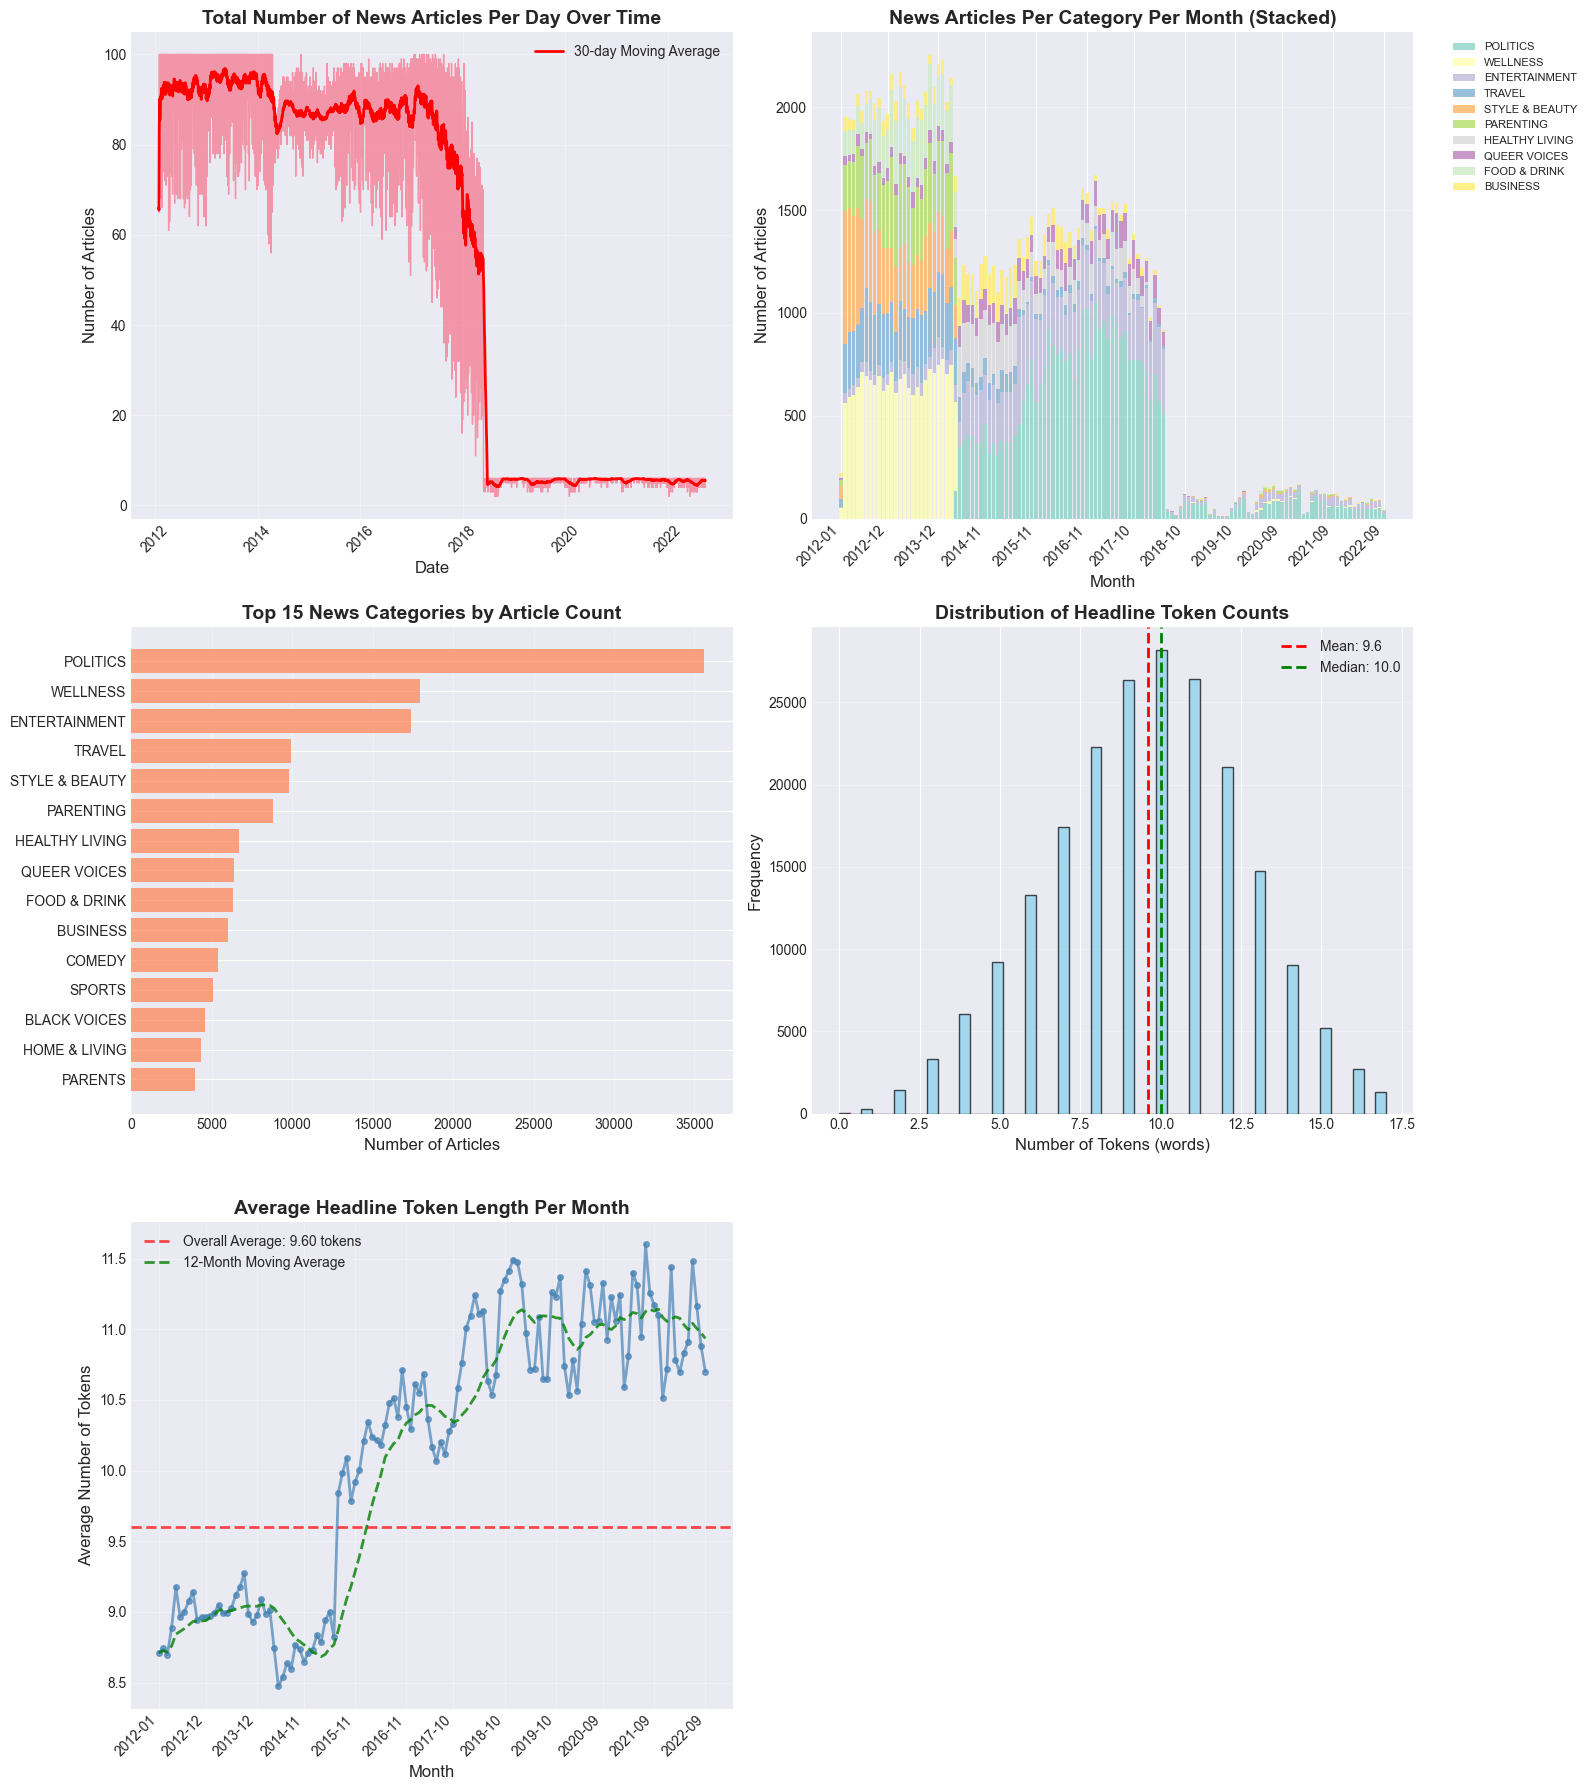


Visualizations created!

Average headline token length statistics:
- Overall average: 9.60 tokens
- Monthly average range: 8.47 - 11.60 tokens
- Monthly average std: 0.96 tokens


In [8]:
# Create visualizations
data_explorer.plot_news_statistics(df_news, daily_counts, monthly_counts, category_counts)


## Observation Summary

### 1. News Volume Over Time
- From **2012 to mid-2018**, the dataset exhibits a **stable and high daily volume** of news articles, averaging roughly **80–100 articles per day**, with moderate short-term fluctuations.
- Around **mid-2018**, there is a **sharp structural break**, after which daily article counts drop dramatically to fewer than **10 articles per day**.
- This discontinuity likely reflects a **data collection or coverage change**, rather than a genuine collapse in news production.
- **Implication:** Post-2018 data may not be directly comparable to earlier periods, requiring regime-aware modeling or robustness checks.

---

### 2. Category Composition Over Time
- Prior to 2018, **Politics, Wellness, Entertainment, and Lifestyle-related categories** dominate overall article volume.
- The category mix is relatively stable over time, with cyclical variation within individual categories.
- After 2018, article counts across **all categories decline simultaneously**, reinforcing the interpretation of a **dataset-level structural break**.
- **Implication:** Category-level features are more informative pre-2018 and may suffer from sparsity afterward.

---

### 3. Category Distribution (Cross-Section)
- **Politics** is by far the most frequent category, followed by **Wellness** and **Entertainment**.
- Business-related articles represent a **smaller fraction** of total headlines.
- This skew suggests that predictive signals extracted from the dataset are likely driven by **broad risk sentiment and macro narratives**, rather than firm-level fundamentals.

---

### 4. Headline Length Distribution
- Headline length is tightly distributed, with:
  - **Mean ≈ 9.6 tokens**
  - **Median ≈ 10 tokens**
- The narrow distribution indicates headlines are **short and standardized**
- Extreme outliers are rare, reducing noise from anomalously long text.

---

### 5. Headline Length Over Time (Complexity Proxy)
- Average headline length increases gradually from **2012 to 2018**, rising from approximately **8.7 to 11 tokens**.
- After 2018, headline length stabilizes around **11 tokens**, with modest month-to-month variation.
- This suggests a **slow shift in editorial style** toward more descriptive or nuanced headlines.
- **Implication:** Raw complexity measures are non-stationary; relative or demeaned features are preferred.

---

### 6. Implications for Feature Engineering and Modeling
- The **2018 structural break** is the most significant characteristic of the dataset and should be explicitly addressed.
- Volume-based features require **normalization or regime-aware interpretation**.
- Sentiment, complexity, and uncertainty features are well-defined given the consistency in headline length.
- Relative (“surprise”) features are likely more informative than absolute levels due to long-term stylistic drift.

---

### Summary Takeaway
Overall, the dataset exhibits **stable structure and rich variation prior to 2018**, making it suitable for extracting short-horizon news-based signals. However, the clear **post-2018 regime shift** necessitates careful handling to avoid spurious inference. Feature normalization, relative measures, and robustness checks are essential for credible modeling.

In [9]:
# Load SPY returns data using DataLoader class
df_spy = data_loader.load_spy_returns()
print(f"\nDataset shape: {df_spy.shape}")
print(f"Columns: {list(df_spy.columns)}")
df_spy.head()


SPY data loaded: 24,608 trading days
Date range: 1928-01-03 00:00:00 to 2025-12-18 00:00:00

Return statistics:
count    24608.000000
mean         0.000242
std          0.011953
min         -0.228997
25%         -0.004551
50%          0.000501
75%          0.005454
max          0.153661
Name: spy_return, dtype: float64

Dataset shape: (24608, 4)
Columns: ['date', 'SP500', 'spy_return', 'spy_return_next']


,date,SP500,spy_return,spy_return_next
1,1928-01-03,17.760000,0.005647,-0.002255
2,1928-01-04,17.719999,-0.002255,-0.009640
3,1928-01-05,17.549999,-0.009640,0.006248
4,1928-01-06,17.660000,0.006248,-0.009101
5,1928-01-09,17.500000,-0.009101,-0.007456


## 1. Data Loading and Preparation

### 1.1 Load News Dataset


In [10]:
extractor = ArticleFeatureExtractor(data_loader=data_loader)

Loading Loughran-McDonald uncertainty words from data/Loughran-McDonald_MasterDictionary_1993-2024.csv...
Loaded 285 uncertainty words from Loughran-McDonald dictionary
Sample words: ['unhedged', 'depended', 'unproven', 'unsettled', 'apparently', 'alteration', 'suggest', 'seems', 'uncertain', 'unidentified']
Loading sentiment model...


`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cpu
Model loaded on device: cpu


In [11]:
# Compute features on individual articles
# Create ArticleFeatureExtractor instance (sentiment model will be initialized automatically)
df_features = extractor.compute_all_features(df_news, reload_cache=True)
df_features.head()

Computing features on individual articles...
Computing complexity features...
Computing uncertainty features...
Loaded 209,527 sentiment results from data/cache/sentiment_cache.parquet
Features computed for 209,527 articles


,link,headline,category,short_description,authors,date,headline_tokens,headline_length,year_month,flesch,...,gunning_fog_normalized,dale_chall_normalized,complexity,uncertainty_count,uncertainty_ratio,sentiment_label,sentiment_score,sentiment_negative,sentiment_neutral,sentiment_positive
0,https://www.huffingtonpost.com/entry/dwight-ho...,Dwight Howard Rips Teammates After Magic Loss ...,SPORTS,The five-time all-star center tore into his te...,,2012-01-28,9,56,2012-01,66.100,...,NaN,NaN,NaN,0,0.0,neutral,-0.318328,0.344627,0.629073,0.026300
1,https://www.huffingtonpost.com/entry/robots-pl...,"Robots Play Catch, Starring Agile Justin And R...",SCIENCE,"image 1: throw As Hizook reports, DLR started ...",Travis Korte,2012-01-28,10,67,2012-01,44.405,...,NaN,NaN,NaN,0,0.0,neutral,0.071751,0.012370,0.903509,0.084121
2,https://www.huffingtonpost.com/entry/russian-c...,Russian Cargo Ship Docks At International Spac...,SCIENCE,Gallery: Space Station's Expedition 30 Mission...,,2012-01-28,8,55,2012-01,40.090,...,NaN,NaN,NaN,0,0.0,neutral,-0.011990,0.043569,0.924853,0.031579
3,https://www.huffingtonpost.com/entry/7-amazing...,7 Amazing Name Generators (PHOTOS),COMEDY,Let's be honest: most of our names are pretty ...,Seena Vali,2012-01-28,5,34,2012-01,15.640,...,NaN,NaN,NaN,0,0.0,positive,0.937695,0.006029,0.050248,0.943724
4,https://www.huffingtonpost.com/entry/mitt-romn...,Mitt Romney Madness: Florida Edition (VIDEO),COMEDY,The apparent madness that gripped Mitt Romney ...,Ben Craw,2012-01-28,6,44,2012-01,3.345,...,NaN,NaN,NaN,0,0.0,neutral,0.043920,0.023460,0.909160,0.067380


## 2. Feature Aggregation, Normalization, and Analysis

This section aggregates article-level features to daily frequency, merges with category-specific features, applies normalization, aligns with SPY returns, and performs feature analysis.


In [12]:
# ============================================================================
# FEATURE AGGREGATION, NORMALIZATION, AND ANALYSIS
# ============================================================================

# Import FeatureAnalyzer class from feature_analyzer.py
from feature_analyzer import FeatureAnalyzer

print("FeatureAnalyzer class imported!")


FeatureAnalyzer class imported!


In [13]:
# Aggregate and normalize features (daily + by category)
# This function:
# 1. Aggregates features to daily frequency (overall)
# 2. Aggregates features to daily frequency by category  
# 3. Merges both with category_feature_name columns
# 4. Applies rolling window z-score normalization
feature_analyzer = FeatureAnalyzer()
daily_features = feature_analyzer.aggregate_and_normalize_features(
    df_features,
    window_size=90,
    min_periods=30
)
print(f"\nFeatures shape: {daily_features.shape}")
print(f"Feature columns: {len([c for c in daily_features.columns if c != 'date'])}")
print(f"\nFirst few rows:")
daily_features.head()


Aggregating and normalizing features
Aggregating features to daily frequency...
Aggregated to 3,890 unique dates
Average headlines per day: 53.9
Aggregating features to daily frequency by category...
Aggregated to 44,094 date-category combinations
Unique categories: 42
Date range: 2012-01-28 00:00:00 to 2022-09-23 00:00:00

Preparing category features for merge...
Merged features: 3,890 rows, 216 columns
Normalizing 215 features using rolling window z-score...
Window size: 90 days, Min periods: 30
Created normalized columns: sentiment_score_normalized, complexity_normalized, average_token_length_normalized, headline_count_normalized, sentiment_ratio_normalized, ARTS_average_token_length_normalized, ARTS & CULTURE_average_token_length_normalized, BLACK VOICES_average_token_length_normalized, BUSINESS_average_token_length_normalized, COLLEGE_average_token_length_normalized, COMEDY_average_token_length_normalized, CRIME_average_token_length_normalized, CULTURE & ARTS_average_token_length_

,date,sentiment_score,complexity,average_token_length,headline_count,sentiment_ratio,ARTS_average_token_length,ARTS & CULTURE_average_token_length,BLACK VOICES_average_token_length,BUSINESS_average_token_length,...,TECH_sentiment_score_normalized,THE WORLDPOST_sentiment_score_normalized,TRAVEL_sentiment_score_normalized,U.S. NEWS_sentiment_score_normalized,WEDDINGS_sentiment_score_normalized,WEIRD NEWS_sentiment_score_normalized,WELLNESS_sentiment_score_normalized,WOMEN_sentiment_score_normalized,WORLD NEWS_sentiment_score_normalized,WORLDPOST_sentiment_score_normalized
0,2012-01-28,0.115905,2.194922,9.257576,66,0.090909,NaN,NaN,NaN,8.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-01-29,-0.008572,2.301621,8.338462,65,-0.030769,NaN,NaN,7.666667,7.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-01-30,0.003290,2.466778,8.780000,100,-0.080000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-01-31,0.066248,2.351000,8.520000,100,0.050000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-02-01,0.101706,2.423050,9.120000,100,0.020000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Align features with SPY returns using one-day lag
# Features from day t-1 are used to predict returns on day t
df_merged = feature_analyzer.align_features_with_spy(daily_features, df_spy)
print(f"\nMerged dataset shape: {df_merged.shape}")
print(f"Date range: {df_merged['date'].min()} to {df_merged['date'].max()}")



Aligning features with SPY returns...
Applying one-day lag to 430 feature columns...
Final merged dataset: 2,681 observations
Date range: 2012-01-31 00:00:00 to 2022-09-23 00:00:00
Features aligned: 430 original + 430 lagged

Merged dataset shape: (2681, 863)
Date range: 2012-01-31 00:00:00 to 2022-09-23 00:00:00


In [22]:
# Keep only *_normalized_lag features and remove the '_normalized_lag' suffix from column names
# This keeps only the normalized lagged features for modeling
normalized_lag_cols = [col for col in df_merged.columns if col.endswith('_normalized_lag')]

# Create a new dataframe with only normalized lagged features
df_features_clean = df_merged[['date', 'spy_return', 'spy_return_next'] + normalized_lag_cols].copy()

# Remove '_normalized_lag' suffix from feature column names
rename_dict = {col: col.replace('_normalized_lag', '') for col in normalized_lag_cols}
df_features_clean = df_features_clean.rename(columns=rename_dict)

print(f"Kept {len(normalized_lag_cols)} normalized lagged features")
print(f"Final dataset shape: {df_features_clean.shape}")
print(f"\nFeature columns (first 10):")
feature_cols_clean = [c for c in df_features_clean.columns if c not in ['date', 'spy_return', 'spy_return_next']]

Kept 215 normalized lagged features
Final dataset shape: (2681, 218)

Feature columns (first 10):


### 2.1 Feature-Level Analysis

Use data from 2012 to 2018 to Evaluate the standalone behavior of individual features using correlation and information coefficients, complemented by simple long–short return analyses, to assess their directional consistency.


In [23]:
# Analyze all features and create summary table
df_features_is = df_features_clean[df_features_clean['date'] < '2019-12-31'].copy()
feature_analysis_results = feature_analyzer.analyze_all_features(df_features_is)
feature_analysis_results.head(20)


,feature,pearson_r,pearson_p,spearman_r,spearman_p,long_short_spread,long_mean,short_mean,t_stat,sharpe_ratio,n_long,n_short
0,sentiment_score,0.035437,0.113853,0.046400,0.038384,0.000950,0.000927,-0.000023,2.618810,0.930000,996.0,996.0
1,complexity,0.016355,0.465664,0.020478,0.360987,0.000322,0.000611,0.000288,0.887354,0.329289,1012.0,980.0
2,average_token_length,-0.011368,0.612103,-0.007077,0.752250,-0.000128,0.000388,0.000516,-0.352259,-0.125096,996.0,996.0
3,headline_count,0.014996,0.503550,0.005855,0.793988,0.000245,0.000575,0.000329,0.675219,0.240675,997.0,995.0
4,sentiment_ratio,0.027826,0.214457,0.039507,0.077924,0.000945,0.000925,-0.000020,2.604840,0.925039,996.0,996.0
5,ARTS_average_token_length,0.025521,0.254910,0.002608,0.907396,0.001183,0.000494,-0.000689,1.207829,0.981678,1921.0,71.0
6,ARTS & CULTURE_average_token_length,0.000987,0.964877,-0.015307,0.494738,0.000087,0.000486,0.000399,0.233264,0.285613,1227.0,765.0
7,BLACK VOICES_average_token_length,0.027907,0.213135,0.001461,0.948037,0.000266,0.000557,0.000291,0.714960,0.437177,1209.0,783.0
8,BUSINESS_average_token_length,-0.035196,0.116326,-0.028107,0.209871,-0.000324,0.000303,0.000627,-0.888465,-0.245297,1074.0,918.0
9,COLLEGE_average_token_length,-0.045619,0.041765,-0.033085,0.139909,-0.000549,0.000394,0.000942,-0.933450,0.490242,1779.0,213.0


### 2.2 Feature Visualization

Visualize the top features ranked by different performance measures.


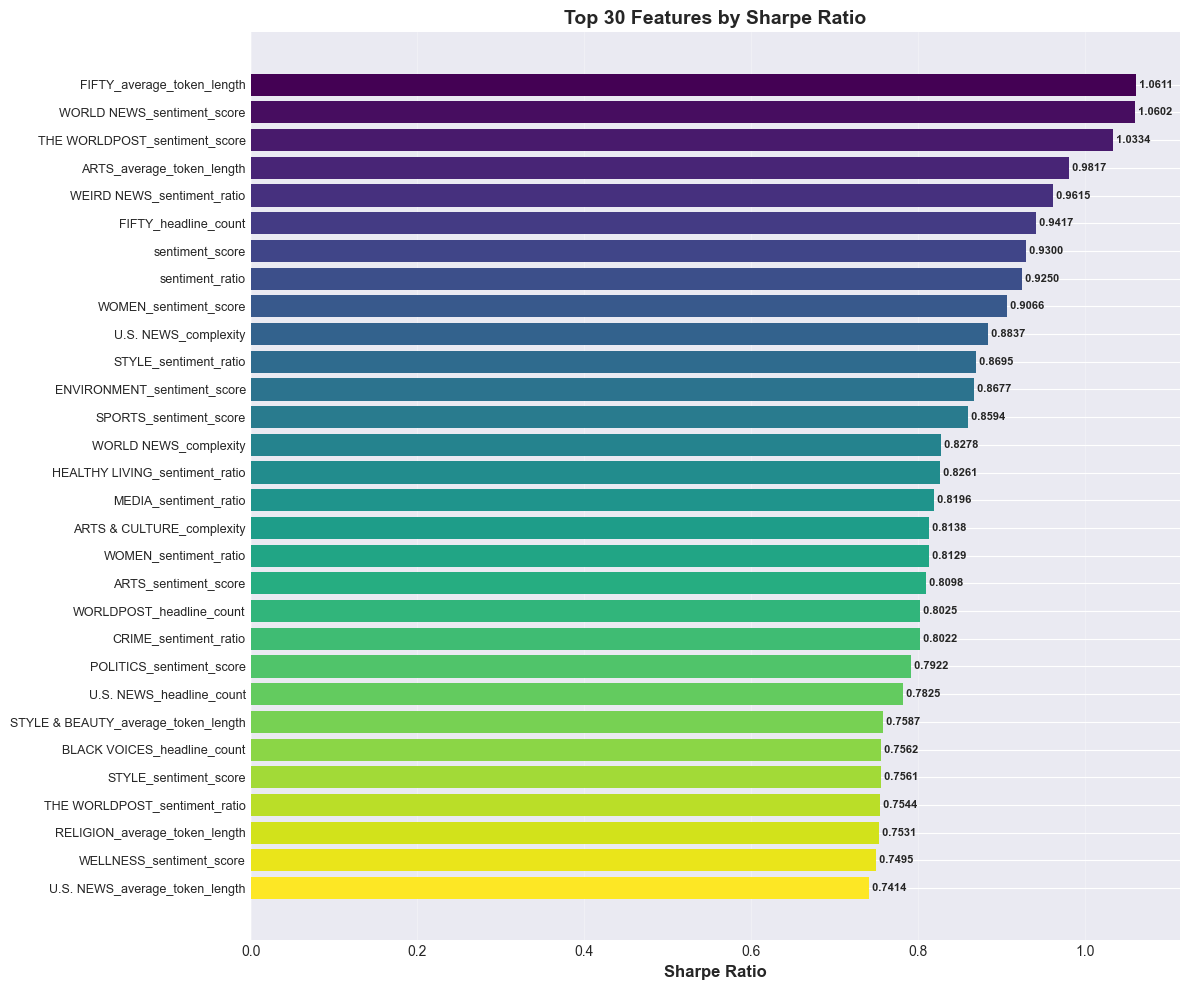

(<Figure size 1200x1000 with 1 Axes>,
 <Axes: title={'center': 'Top 30 Features by Sharpe Ratio'}, xlabel='Sharpe Ratio'>)

In [ ]:
# Visualize top 30 features by Sharpe ratio
feature_analyzer.plot_top_features(feature_analysis_results, measure='sharpe_ratio', top_n=15)


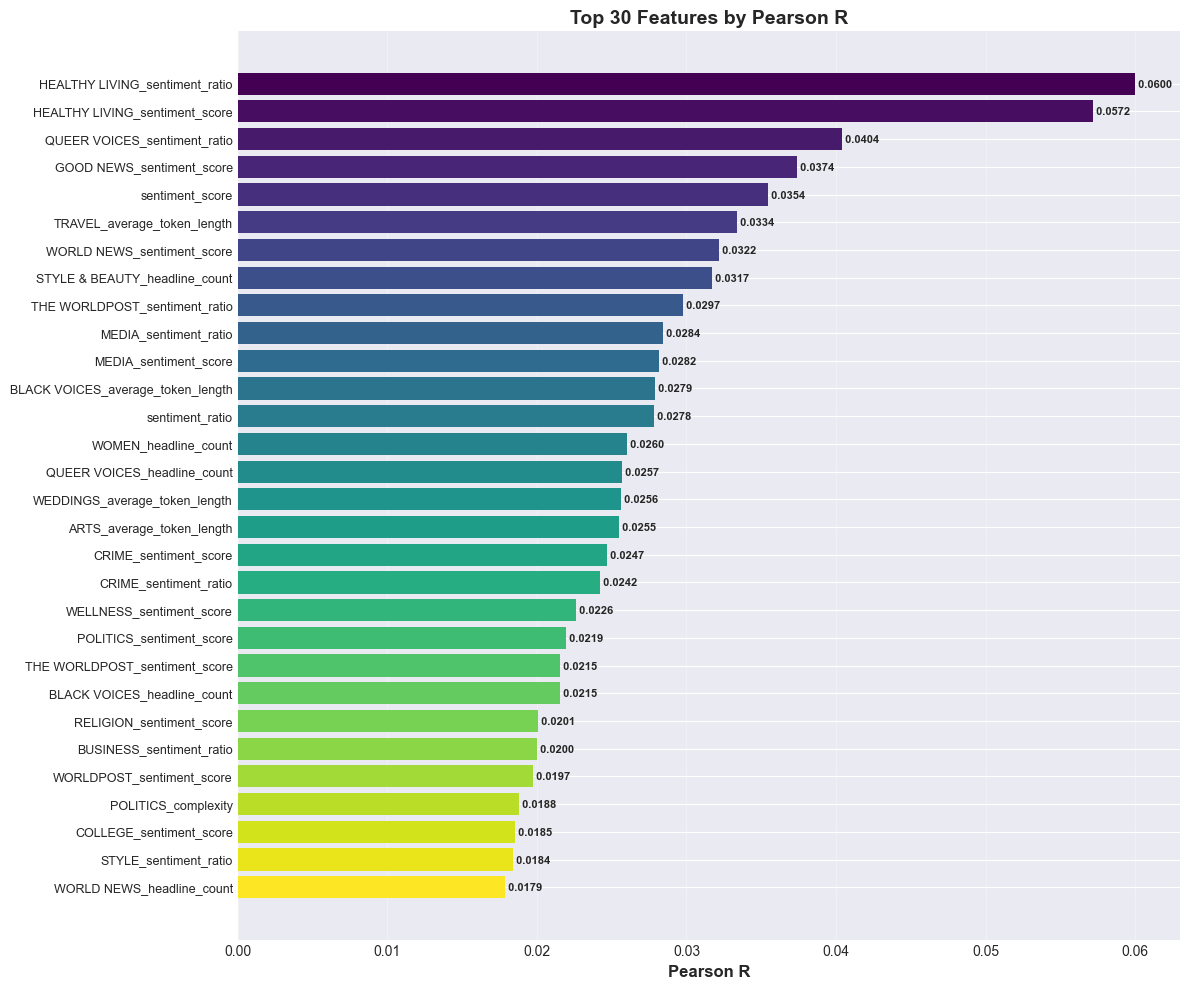

(<Figure size 1200x1000 with 1 Axes>,
 <Axes: title={'center': 'Top 30 Features by Pearson R'}, xlabel='Pearson R'>)

In [ ]:
# Visualize top 30 features by Pearson correlation
feature_analyzer.plot_top_features(feature_analysis_results, measure='pearson_r', top_n=15)


### 2.3 Feature Pairwise Correlation Analysis

Analyze correlations between features to identify multicollinearity and redundant features.


Computing pearson pairwise correlations for 210 features...


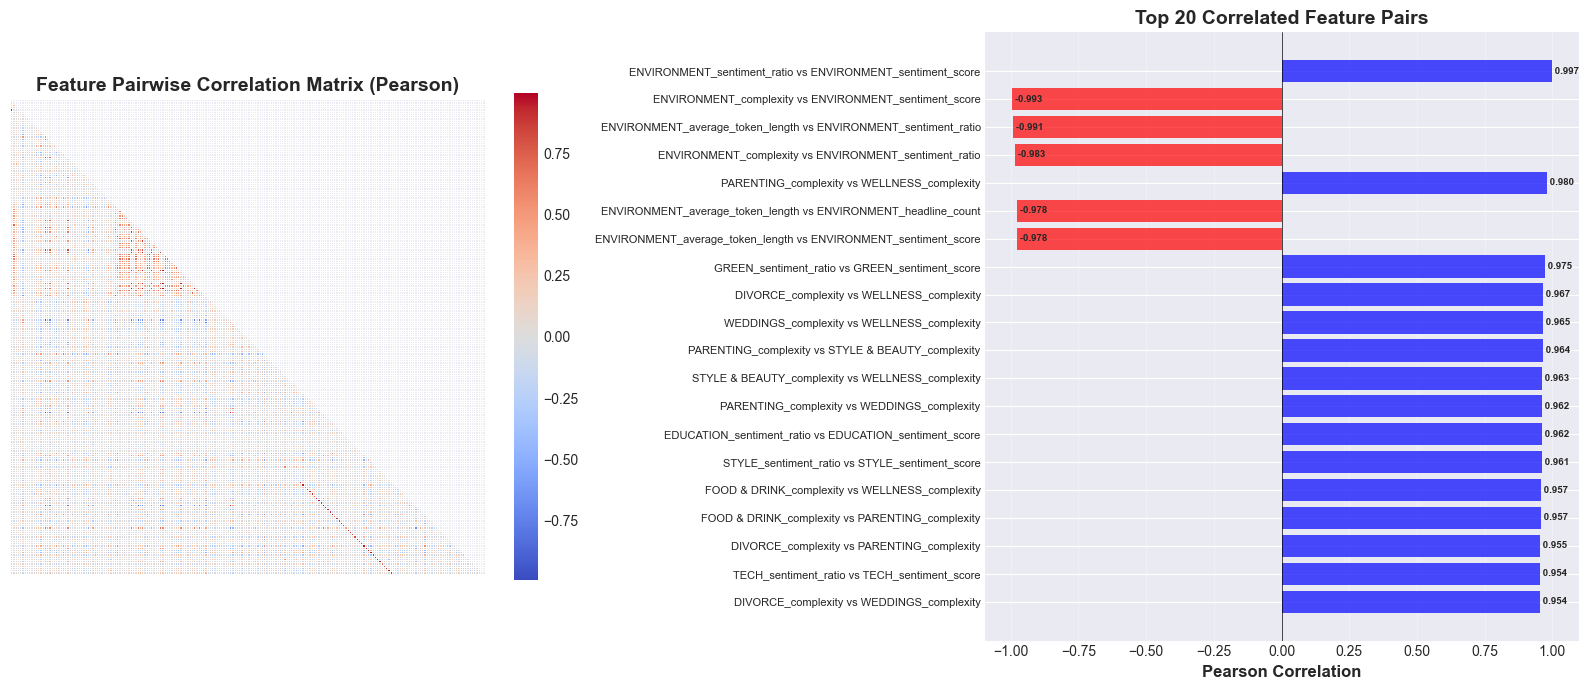


Correlation Summary:
  Total feature pairs: 21945
  Mean absolute correlation: 0.9698
  Max absolute correlation: 0.9974
  Min absolute correlation: 0.9541

Top 20 correlated pairs:
                       feature_1                   feature_2  correlation
     ENVIRONMENT_sentiment_ratio ENVIRONMENT_sentiment_score     0.997358
          ENVIRONMENT_complexity ENVIRONMENT_sentiment_score    -0.993485
ENVIRONMENT_average_token_length ENVIRONMENT_sentiment_ratio    -0.990564
          ENVIRONMENT_complexity ENVIRONMENT_sentiment_ratio    -0.982581
            PARENTING_complexity         WELLNESS_complexity     0.980499
ENVIRONMENT_average_token_length  ENVIRONMENT_headline_count    -0.978165
ENVIRONMENT_average_token_length ENVIRONMENT_sentiment_score    -0.977990
           GREEN_sentiment_ratio       GREEN_sentiment_score     0.974590
              DIVORCE_complexity         WELLNESS_complexity     0.967139
             WEDDINGS_complexity         WELLNESS_complexity     0.964519
   

In [28]:
# Analyze pairwise correlations between features
corr_matrix, top_correlations = feature_analyzer.analyze_pairwise_correlations(
    df_features_is, 
    feature_cols=feature_cols_clean,
    method='pearson',
    figsize=(16, 14),
    top_pairs=20
)


Analyzing distributions for 210 features...

FEATURE DISTRIBUTION SUMMARY STATISTICS
                            feature  count      mean      std       min      max    median       q25       q75  skewness  kurtosis  missing_pct
                    sentiment_score   1992  0.009067 1.009600 -3.931684 3.388812 -0.011963 -0.666707  0.668658  0.064960  0.054765          0.0
                         complexity   1992  0.016730 1.020770 -3.045086 3.725201  0.000000 -0.680475  0.665122  0.125014  0.133075          0.0
               average_token_length   1992  0.025668 0.974795 -4.379236 4.244290  0.002235 -0.627242  0.684780  0.003754  0.494830          0.0
                     headline_count   1992  0.302125 0.708602 -4.374484 2.325615  0.589337  0.228808  0.642493 -2.157248  5.834971          0.0
                    sentiment_ratio   1992 -0.000456 1.012283 -3.424426 3.204827  0.001133 -0.655116  0.689285 -0.050780  0.052743          0.0
          ARTS_average_token_length   1992 -0.55869

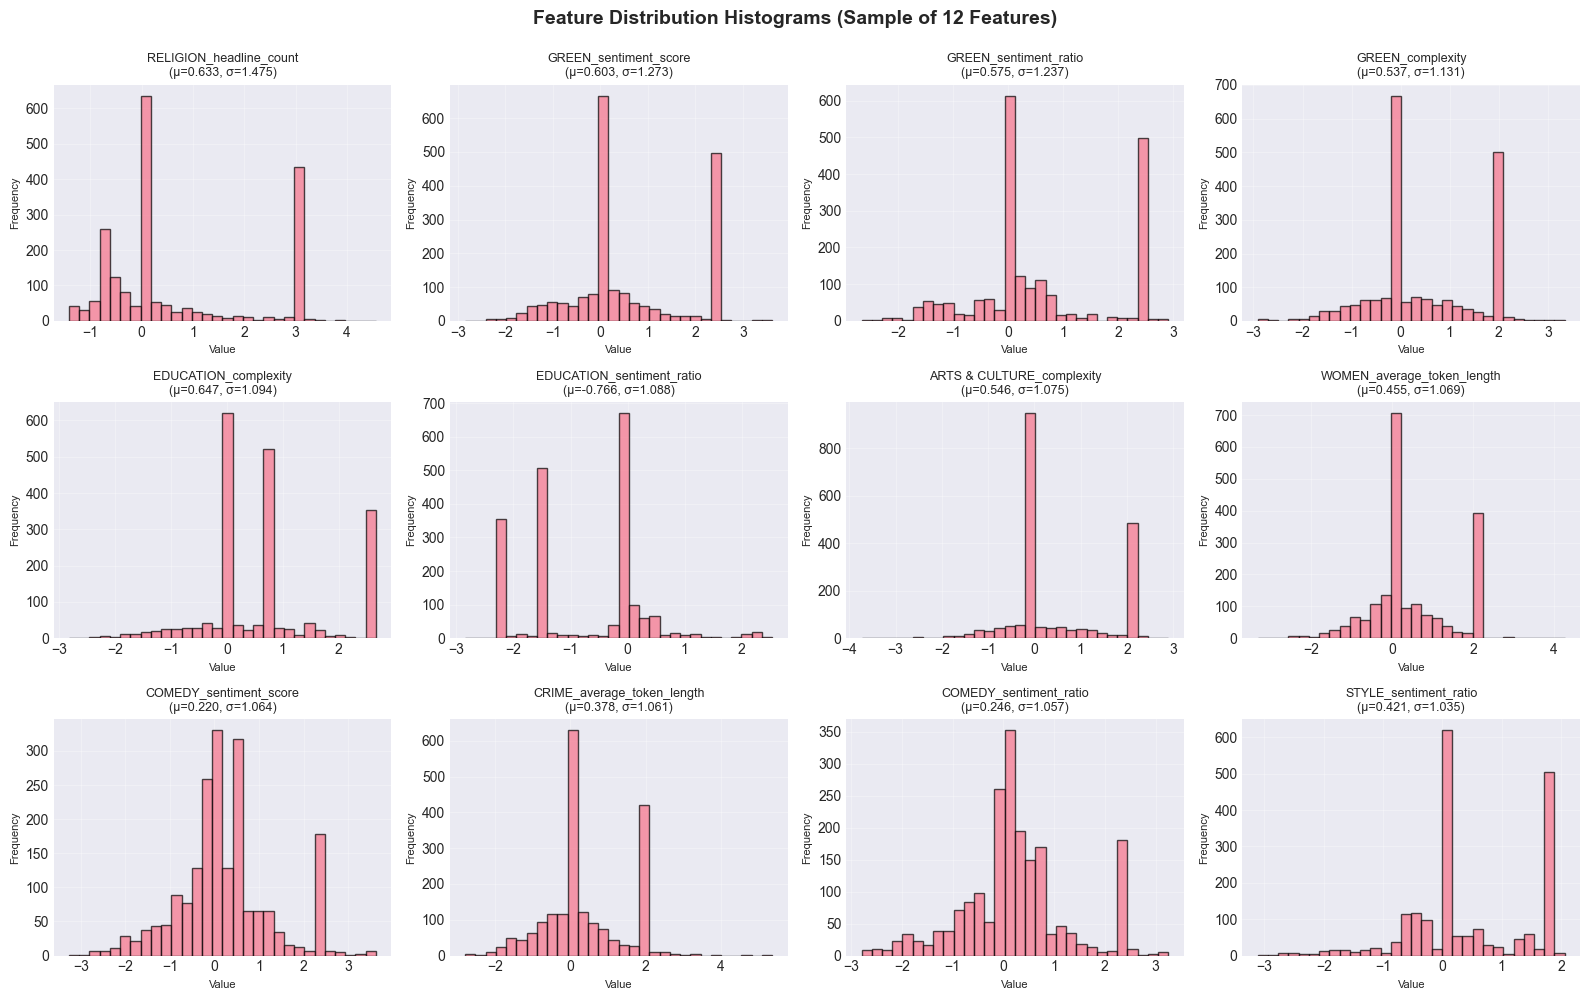

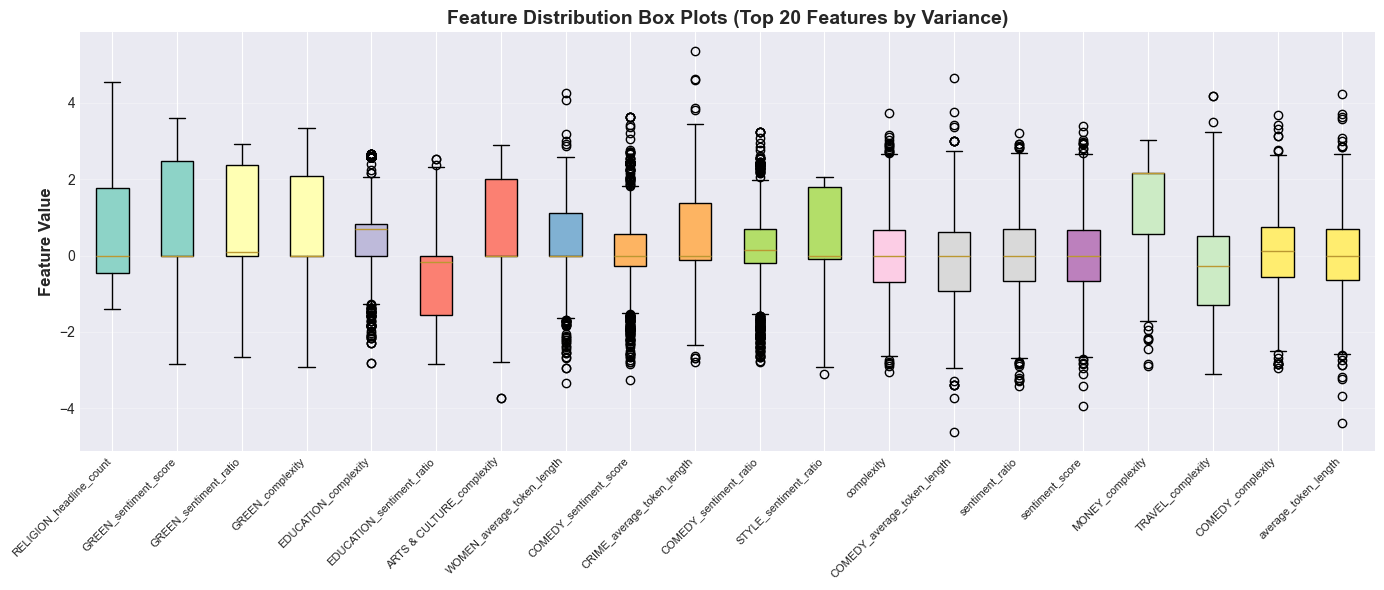

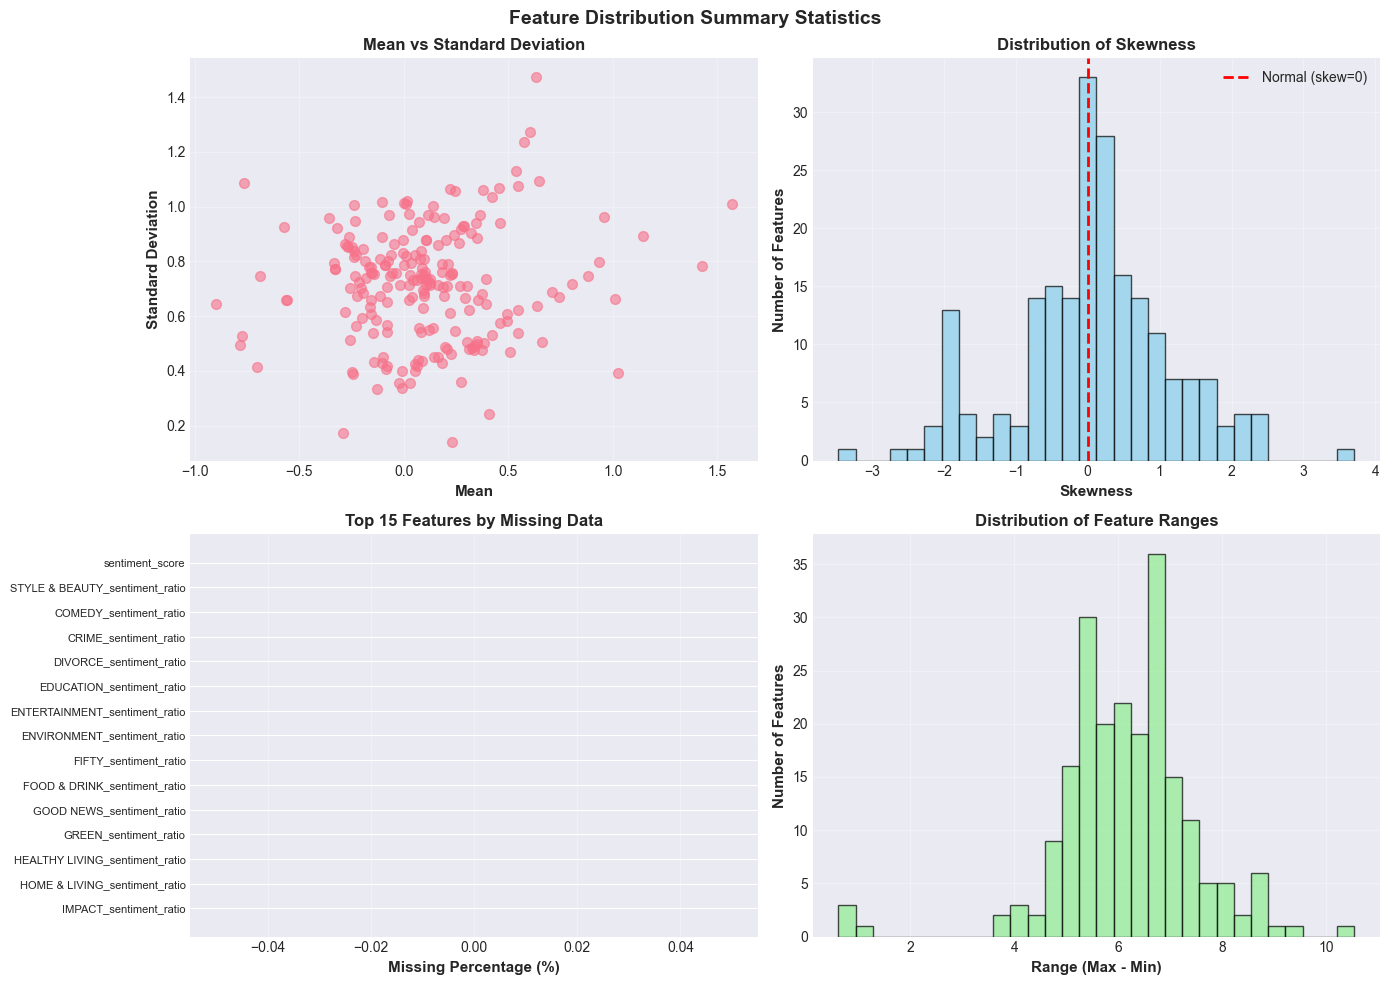


Distribution analysis complete


In [31]:
# Analyze feature distributions
stats_df = feature_analyzer.analyze_feature_distributions(df_features_is, feature_cols_clean)

## Feature Analysis Summary (Exploratory Diagnostics)

This section summarizes what is learned from basic distribution and correlation diagnostics on the engineered daily news features (overall + per-category).

### Dataset coverage
- **~210 engineered features** are created over **~1,992 daily observations**.

### Scale and normalization
- Core aggregated features such as `sentiment_score`, `sentiment_ratio`, `complexity`, and `average_token_length` appear **roughly standardized** (means near 0, standard deviations near 1).  

### Feature distributions: non-Gaussian + sparsity effects
- Many features are **approximately symmetric** (skewness near 0), but a meaningful subset exhibits **heavy tails / outliers** (high kurtosis).
- Category-specific activity features (e.g., `*_headline_count`) often look **sparse and bursty** (many days near zero, punctuated by spikes), which naturally leads to **non-normal distributions** and heavy tails.

### Collinearity is a major issue
- Pairwise correlations are **extremely high on average** (mean absolute correlation ~0.97), with many feature pairs reaching **|ρ| ≈ 0.95–0.997**.
- This indicates substantial **feature redundancy**, likely driven by:
  - multiple representations of the same underlying signal (e.g., sentiment score vs sentiment ratio),
  - category features that are mechanically related (e.g., counts vs derived averages),
  - shared underlying drivers such as news volume.

**Implication:** Unregularized linear models (OLS) will likely have **unstable coefficients** and inflated variance. Regularization and/or dimensionality reduction is important for robust out-of-sample performance.

### Predictive strength (univariate) is modest
- The strongest single-feature Pearson correlations with the target are small (top values around **0.02–0.06**).
- This is expected in index return prediction from headlines: the signal-to-noise ratio is typically low.
